<a href="https://colab.research.google.com/github/BatoolMM/fastai/blob/master/Chapter_4_Under_the_Hood_Training_a_Digit_Classifier_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chapter 4. Under the Hood: Training a Digit Classifier**

In [ ]:
!pip install -Uqq fastbook
!pip install fastcore==1.0.9
!pip install fastai
!pip install utils

In [2]:
from utils import *
from fastai.vision.all import *
from fastai.vision.widgets import ImageClassifierCleaner

In [3]:
?download_images

In [13]:
path = untar_data(URLs.MNIST_SAMPLE)

In [ ]:
path.ls()

In [16]:
(path/'train'/'7').ls()

(#6265) [Path('/root/.fastai/data/mnist_sample/train/7/55344.png'),Path('/root/.fastai/data/mnist_sample/train/7/3579.png'),Path('/root/.fastai/data/mnist_sample/train/7/11703.png'),Path('/root/.fastai/data/mnist_sample/train/7/30902.png'),Path('/root/.fastai/data/mnist_sample/train/7/33315.png'),Path('/root/.fastai/data/mnist_sample/train/7/2865.png'),Path('/root/.fastai/data/mnist_sample/train/7/6053.png'),Path('/root/.fastai/data/mnist_sample/train/7/56410.png'),Path('/root/.fastai/data/mnist_sample/train/7/58589.png'),Path('/root/.fastai/data/mnist_sample/train/7/7509.png')...]

In [19]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [27]:
tensor_threes = [tensor(Image.open(i)) for i in threes]
tensor_sevens = [tensor(Image.open(i)) for i in sevens]
tensor_threes[1][4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

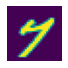

In [26]:
show_image(tensor_sevens[1])